In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
import sys
sys.path.append('../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

# KNN

## Train Test Split

In [4]:
ip_address = '18.218.116.177'
raw = fetch_model_data.fetch_model_data(ip_address)

In [5]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
    'first_word_approp',
]

In [6]:
X, y = raw[first_feature_set], raw.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

## Metric Selection

In [7]:
# ROC for overall model quality
# Accuracy for interpretability
# Precision (don't want to say a bill will pass and be wrong)

## Baseline KNN

In [14]:
scores = evaluation.cross_validate(
    KNeighborsClassifier,
    X_train,
    y_train,
    scoring=['roc_auc', 'accuracy', 'precision'],
    cv=5,
    standardize=True
)
evaluation.report_single_model_metrics(scores)

,metric,mean,std,in_sample
0,roc_auc,0.826088,0.025711,0.880524
1,accuracy,0.798318,0.062970,0.808465
2,precision,0.793129,0.090827,0.801030


In [15]:
# Perhaps a little overfit.
# Doing pretty well actually

## Tune Parameters

In [16]:
grid_results, best_params = evaluation.report_grid_results(X_train, y_train, KNeighborsClassifier(), param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']})

In [17]:
grid_results.head()

,params,mean_test_score,std_test_score,mean_train_score,rank_test_score
26,"{'n_neighbors': 14, 'weights': 'uniform'}",0.864348,0.010223,0.887046,1
28,"{'n_neighbors': 15, 'weights': 'uniform'}",0.862880,0.009782,0.886229,2
24,"{'n_neighbors': 13, 'weights': 'uniform'}",0.862640,0.010087,0.889033,3
22,"{'n_neighbors': 12, 'weights': 'uniform'}",0.862252,0.011776,0.890352,4
18,"{'n_neighbors': 10, 'weights': 'uniform'}",0.861925,0.012948,0.893081,5


## All Features

In [18]:
evaluation.run_pipeline(raw, first_feature_set, KNeighborsClassifier, param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']})

Best params: {'n_neighbors': 14, 'weights': 'uniform'}


,metric,mean,std,in_sample
0,roc_auc,0.846473,0.016398,0.874434
1,accuracy,0.797601,0.072992,0.800419
2,precision,0.798095,0.098726,0.797202


In [19]:
# all three metrics improved

## Different Features

In [23]:
second_feature_set = [
#     'author_ideology',
    'author_party',
#     'author_is_chair',
#     'author_years_sen',
#     'author_total_funding',
    'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
#     'ideol_range',
#     'first_word_approp',
]

evaluation.run_pipeline(
    estimator=KNeighborsClassifier,
    raw_data=raw,
    features=second_feature_set,
    standardize=True,
    param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
)

Best params: {'n_neighbors': 13, 'weights': 'uniform'}


,metric,mean,std,in_sample
0,roc_auc,0.840169,0.017991,0.859997
1,accuracy,0.811178,0.023155,0.816704
2,precision,0.826370,0.024404,0.831292


In [ ]:
# Every metric got better

In [24]:
third_feature_set = [
    'author_ideology',
#     'author_party',
    'author_is_chair',
#     'author_years_sen',
#     'author_total_funding',
    'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
#     'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

evaluation.run_pipeline(
    estimator=KNeighborsClassifier,
    raw_data=raw,
    features=third_feature_set,
    standardize=True,
    param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
)

Best params: {'n_neighbors': 14, 'weights': 'uniform'}


,metric,mean,std,in_sample
0,roc_auc,0.857910,0.020416,0.882145
1,accuracy,0.819754,0.021164,0.823676
2,precision,0.831148,0.020752,0.832751


In [ ]:
# Even better

In [25]:
fourth_feature_set = [
#     'author_ideology',
#     'author_party',
#     'author_is_chair',
    'author_years_sen',
#     'author_total_funding',
#     'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
    'total_slips',
#     'slips_perc_pro',
#     'bipartisan',
#     'ideol_range',
#     'first_word_approp',
]

evaluation.run_pipeline(
    estimator=KNeighborsClassifier,
    raw_data=raw,
    features=fourth_feature_set,
    standardize=True,
    param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
)

Best params: {'n_neighbors': 17, 'weights': 'uniform'}


,metric,mean,std,in_sample
0,roc_auc,0.855938,0.018188,0.877801
1,accuracy,0.820458,0.020381,0.822604
2,precision,0.829572,0.022423,0.830665


## Tune Threshold

In [27]:
s = evaluation.cross_validate(
    KNeighborsClassifier,
    X_train,
    y_train,
    standardize=True,
    scoring=['roc_auc', 'accuracy', 'precision'],
    cv=5,
    fit_params={'n_neighbors': 17, 'weights': 'uniform'}
)
evaluation.report_single_model_metrics(s)

,metric,mean,std,in_sample
0,roc_auc,0.857970,0.017623,0.884168
1,accuracy,0.831180,0.016734,0.833334
2,precision,0.835193,0.020210,0.836938


0.8261904761904761


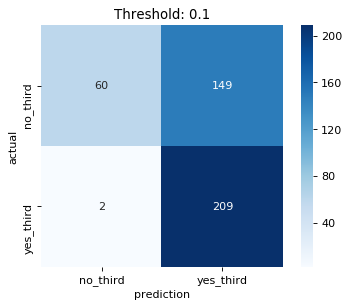

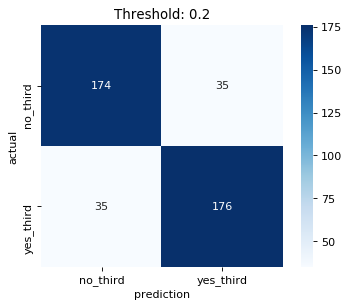

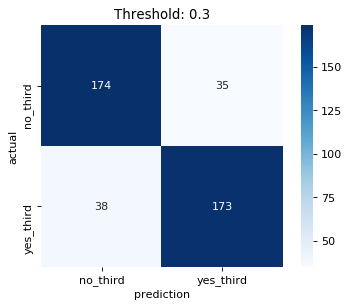

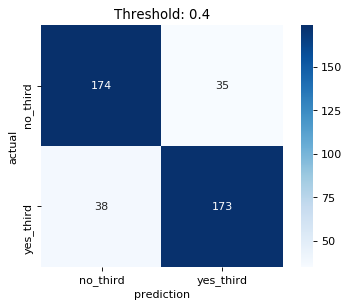

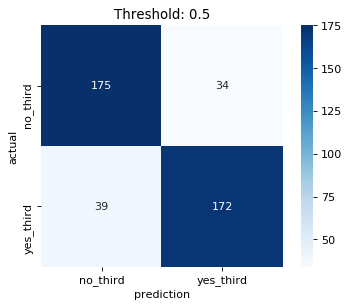

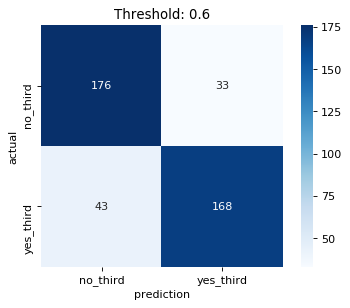

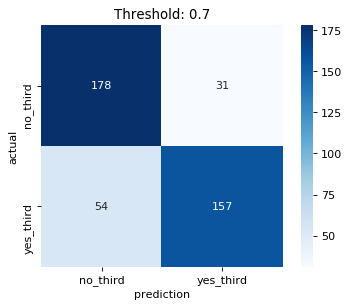

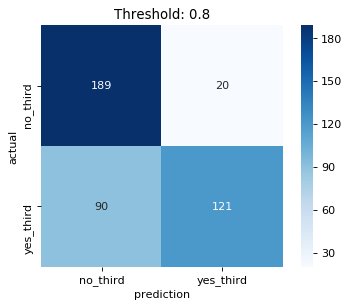

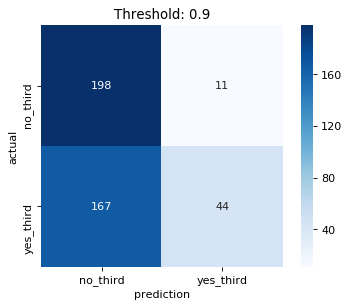

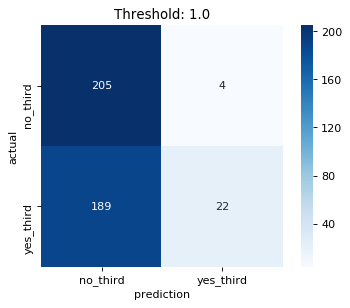

In [29]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
knn = KNeighborsClassifier(**{'n_neighbors': 17, 'weights': 'uniform'})
knn.fit(X_tr, y_tr)
print(knn.score(X_val, y_val))
for t in [x / 10 for x in range(1, 11)]:
    evaluation.make_confusion_matrix(X_val, y_val, knn, ['no_third', 'yes_third'], f'Threshold: {t}', t)

In [ ]:
# Difficult to get precision better without exploding recall
# 0.5 actually looks like the best threshold

#### Conclusion: KNN with {'n_neighbors': 17, 'weights': 'uniform'} and threshold = 0.5